In [1]:
# imports and loadings
import os
import shutil
import sys
sys.path.insert(0, '../functions/')
import create_data_for_single_gene as cdg
import interface_GAMS as iG
import parameter_optimization as po
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import numpy as np
import pickle
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
testing = True
    
# load in settings flags
if testing:
    flags_filepath = '../options/test_gene_flags.csv'
else:
    flags_filepath = '../options/gene_flags.csv'
flags_df = pd.read_csv(flags_filepath, index_col = 0)

flags_df = pd.read_csv(flags_filepath, index_col = 0)
flags_df = flags_df[flags_df['include'] == True]
        
# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
t_half_life_deg = 300
stable_flags = { # these do not change gene by gene
    # overall
    'run_basal_calculations' : False, # it is very slow and should only be necessary to run if something has changed basal conditions
    'only_create_ratios' : False,
    'only_check_KdRNAPCrp' : True, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'save_gene_specific_results' : False, # only works if save_results is True, if this is True, saves the plots from the most recent run of said gene and overwrites any old results there
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : False, # only used for remove_outliers right now
    'drop_basal_conds' : True, # if True, removes basal conditions from sample after they're used to calculate ratios (useful when their outliers)
    'use_Gabes_corrected_p1k' : False, 
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b2818', 'b3959', 'b3359'], #['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}

#log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
log_tpm_df = pd.read_csv('../data/external/imodulon_info/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/external/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

# picking grid values, custom go through genes run and verify which need modifying and which work

In [17]:
# starting point minus 1
iter_ct = 0 - 1

In [19]:
# print 5 at a time, update excel, move on
def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

    
iter_ct += 1
flags_df = pd.read_csv(flags_filepath, index_col = 0)
flags_df.sort_values(by = ['act_iM', 'inh_iM'])
flags_df = flags_df[[val not in [0, -1, '0', '-1'] for val in flags_df['looks_good']]]
flags_df = flags_df[flags_df['include']]
flags_df = flags_df.iloc[iter_ct*5: iter_ct*5 + 5]

# display gene specific plot
for gene in flags_df.index.to_list():
    try:
        pickle_in = open('../data/saved_gene_results/'+gene+'/figures.pkl', 'rb')
        result = pickle.load(pickle_in)
        pickle_in.close()
    except:
        print(gene+', no results found')
        continue
    result[0].suptitle(gene+' : '+str(flags_df.loc[gene]['act_iM'])+', '+str(flags_df.loc[gene]['inh_iM']), fontsize = 24)
    result[0].tight_layout()
    for res in result:
        show_figure(res)
    
    # save off figures
    ct = 0
    for fig in result:
        try: # this doesn't work on my own computer because of conflicting veresions of matplotlib/pickle that I don't feel like fixing
            fig.figure.savefig('../figures/'+gene+'_'+str(ct)+'.pdf', transparent = True)
        except:
            print(gene)
            pass
        ct += 1

b3081, no results found
b2308, no results found
b2818, no results found
b3172, no results found


# generate grid values and iterate for the ones that need not be 7

In [59]:
# increase 1 each time, start at 0
gene_int = 0

# modify flags_df to use expanded one, just delete these lines to go back
flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)
flags_df = flags_df[flags_df['looks_good'] == 0]
flags_df = flags_df[flags_df['force_rerun'] == True]
flags_df = flags_df.sort_values(by = ['act_iM', 'inh_iM'])
genes = flags_df.index.to_list()

# I want to make it save over, so delete old
for gene in genes:
    run_dir = '../data/saved_grid_results/'+gene
    if os.path.exists(run_dir):
        shutil.rmtree(run_dir)

In [3]:
# multiprocess run
grid_steps = 3 # this is the default

# setup
runs_complete = 0
print('\rprogress : {:.2f}%'.format(100 * runs_complete / len(genes)), end = '\r')

# wrapper func to not quit on first error

# loop through genes, calculate grid possibilities, save
for gene in genes:
    if os.path.exists('../data/saved_grid_results/'+gene):
        runs_complete += 1
        continue
    
    # setup
    runs = []
    run_to_grid_use = {}
    gene_flags = []
    os.mkdir('../data/saved_grid_results/'+gene)
        
    # arrange flags for multiprocessing
    for grid_use in range(0, grid_steps**2): 
        folders = [val for val in os.listdir('../data/saved_grid_results/'+gene) if 'run' in val and '.pkl' not in val]
        if len(folders) == 0:
            run_ct = 1
        else:
            run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
        new_run_folder = '../data/saved_grid_results/'+gene+'/run_'+str(run_ct)
        os.mkdir(new_run_folder)

        # put the flags df in there
        flags_df.loc[gene].to_csv(new_run_folder+'/saved_flags.csv')

        # setup inputs
        runs.append(new_run_folder)
        run_to_grid_use.update({new_run_folder : grid_use})
        temp_flags = dict(flags_df.loc[gene])
        temp_flags.update({'grid_use' : grid_use})
        temp_flags.update({'central_gene' : gene})
        temp_flags.update({'grid_steps' : grid_steps})

        # need to convert some flags from strings to lists
        for col in ['basal_conditions', 'target_range', 'cActivator', 'cInhibitor']:
            temp_flags[col] = ast.literal_eval(temp_flags[col])

        # convert cell constants into a dictionary
        temp_flags.update({'cell_constants' : {
            'RNAP' : stable_flags['cell_constants_RNAP'],
            'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
            'cell_volume' : stable_flags['cell_constants_cell_volume'],
            'kDeg' : stable_flags['cell_constants_kDeg'],
            'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
            'u' : stable_flags['cell_constants_u'],
            'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
        }})
        temp_flags.update({'run_basal_calculations' : stable_flags['run_basal_calculations']})
        temp_flags.update({'eq_str' : stable_flags['eq_str']})
        temp_flags.update({'save_results' : stable_flags['save_results']})
        temp_flags.update({'save_results_folder' : new_run_folder})
        temp_flags.update({'include_Amy_samples' : stable_flags['include_Amy_samples']})
        temp_flags.update({'only_check_KdRNAPCrp' : stable_flags['only_check_KdRNAPCrp']})
        temp_flags.update({'only_create_ratios' : stable_flags['only_create_ratios']})
        temp_flags.update({'KdRNAPCrp_sanity' : stable_flags['KdRNAPCrp_sanity']})
        temp_flags.update({'remove_outliers' : stable_flags['remove_outliers']})
        temp_flags.update({'case' : stable_flags['case']})
        temp_flags.update({'drop_basal_conds' : stable_flags['drop_basal_conds']})
        temp_flags.update({'use_Gabes_corrected_p1k' : stable_flags['use_Gabes_corrected_p1k']})
        temp_flags.update({'save_gene_specific_results' : stable_flags['save_gene_specific_results']})

        gene_flags.append(temp_flags)

    # run pool
    pool = multiprocessing.Pool(processes = 16)
    results = pool.map(cdg.create_data_for_gene, gene_flags)
    pool.close()
    pool.join()

    # save off run_to_grid_use
    pickle_out = open('../data/saved_grid_results/'+gene+'/run_to_grid_use.pkl', 'wb')
    pickle.dump(run_to_grid_use, pickle_out)
    pickle_out.close()
    
    runs_complete += 1
    print('\rprogress : {:.2f}%'.format(100 * runs_complete / len(genes)), end = '\r')
print('\rprogress : {:.2f}%'.format(100 * runs_complete / len(genes)), end = '\r')

<lambdifygenerated-5>:3: RuntimeWarning: invalid value encountered in double_scalars
  return [1.47363764119219e-467*KdRNAPCrp*(-1.07294954057025e+501*cInhibitor*mRNARatio - 1.41289383929571e+501*mRNARatio + 1.41289383929572e+501)/(1.58113883008419e+34*KdRNAPCrp*mRNARatio + 1.58415790245266e+28*mRNARatio - 6.58415790245266e+28)]
<lambdifygenerated-9>:3: RuntimeWarning: invalid value encountered in double_scalars
  return [1.47363764119219e-467*KdRNAPCrp*(-1.07294954057025e+501*cInhibitor*mRNARatio - 1.41289383929571e+501*mRNARatio + 1.41289383929572e+501)/(1.58113883008419e+34*KdRNAPCrp*mRNARatio + 1.58415790245266e+28*mRNARatio - 6.58415790245266e+28)]
<lambdifygenerated-12>:3: RuntimeWarning: invalid value encountered in double_scalars
  return [4.41529324779911e+485*(5.0e+19*KdRNAPCrp + 158113883008419.0*cActivator)/(1.67648365714102e+505*KdRNAPCrp*cActivator + 1.67648365714102e+505*KdRNAPCrp*cInhibitor + 2.20764662389955e+505*KdRNAPCrp + 1.67968478368928e+499*cActivator)]


In [61]:
# starting point minus 1
iter_ct = 0 - 1

/tmp/ipykernel_266526/3124283583.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  dummy = plt.figure()


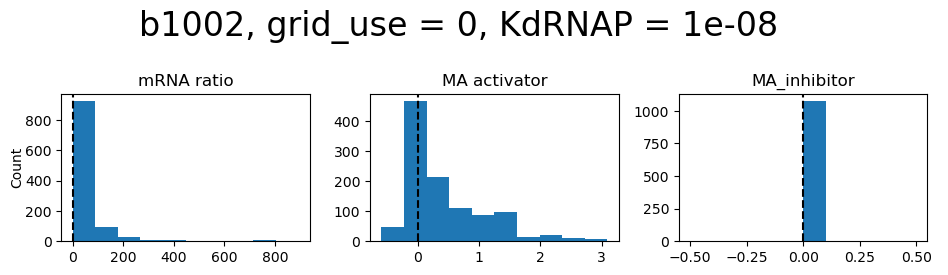

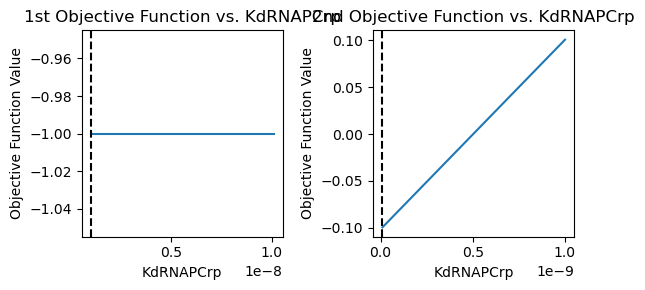

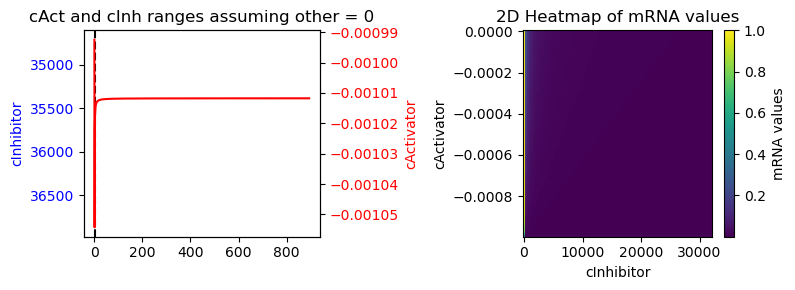

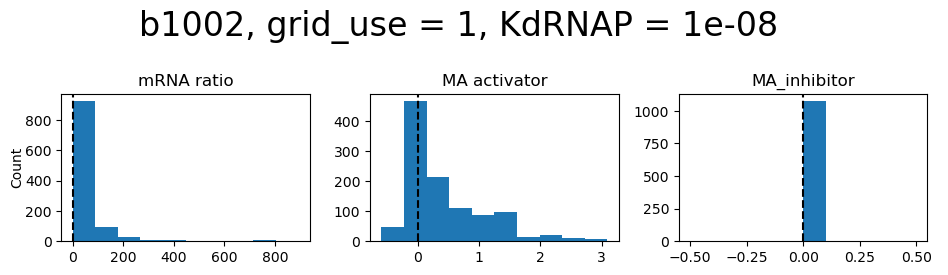

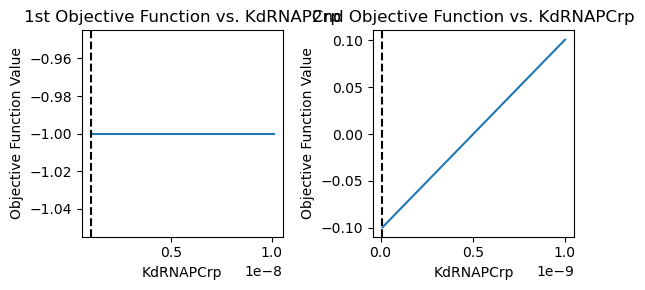

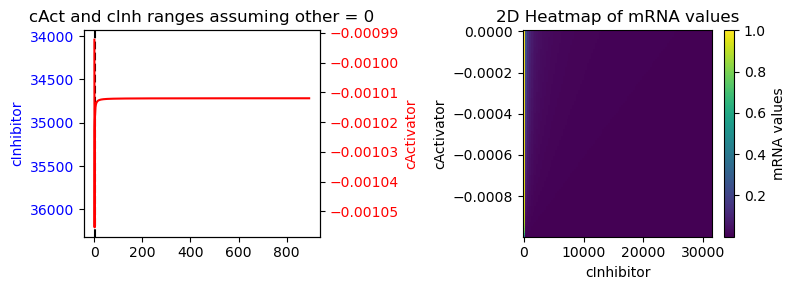

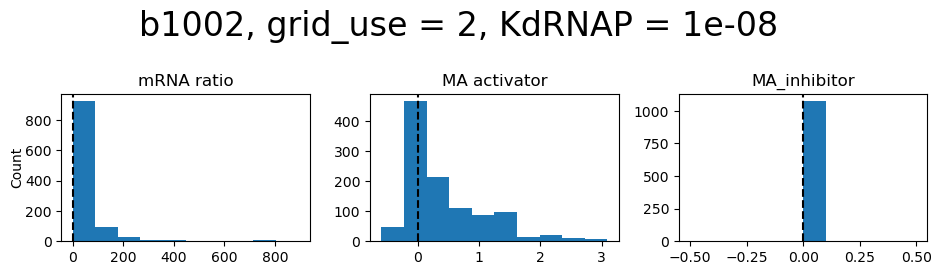

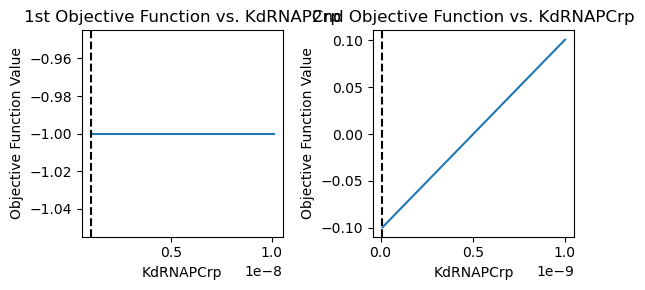

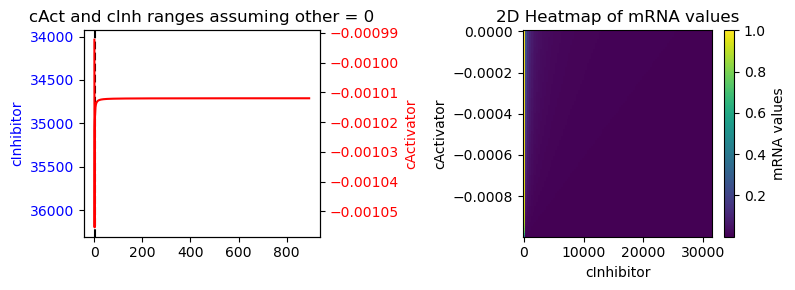

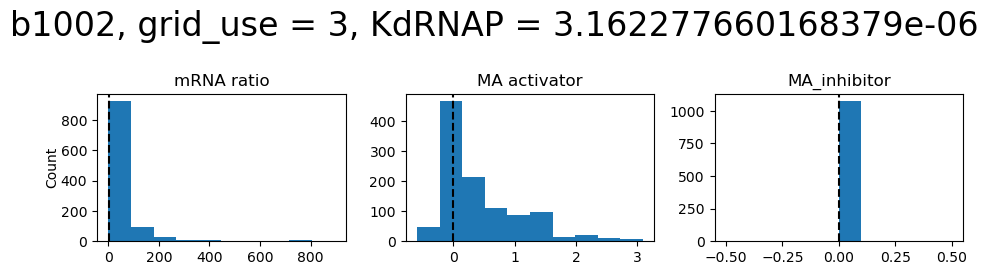

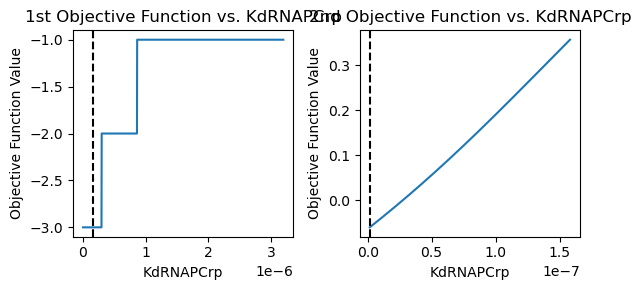

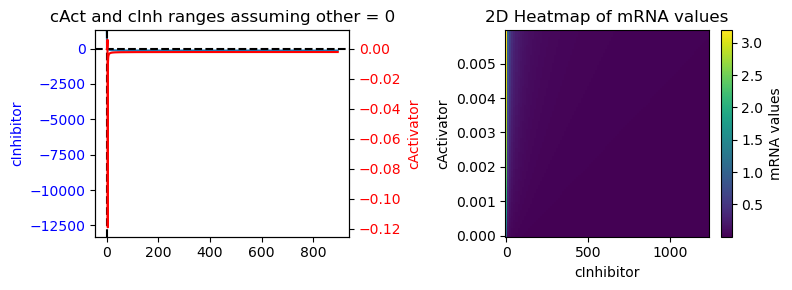

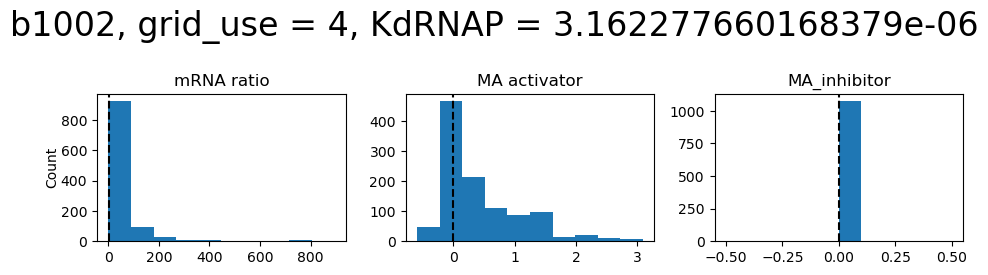

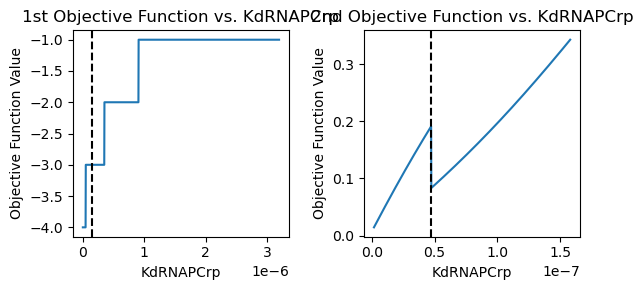

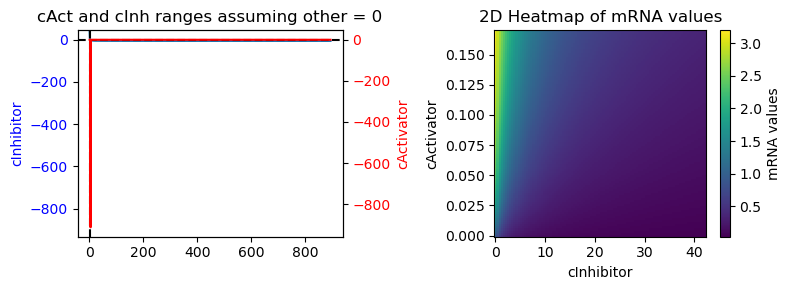

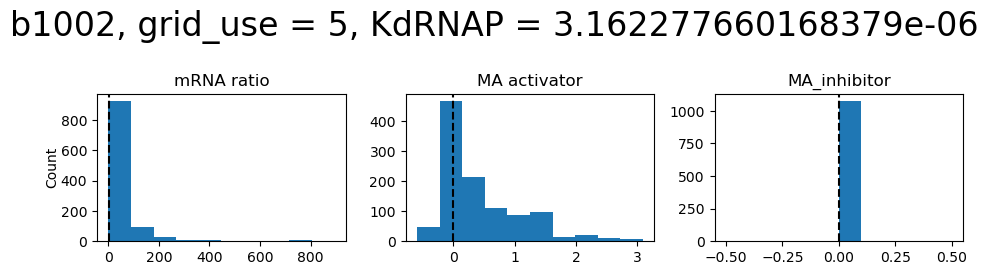

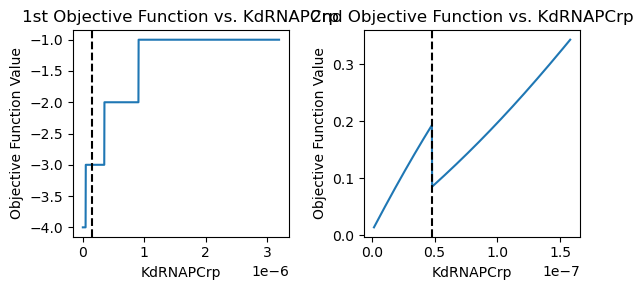

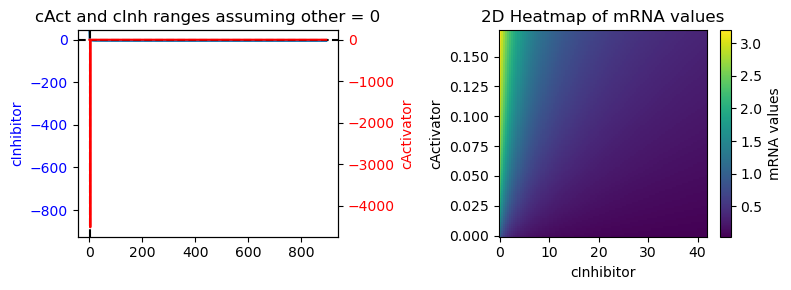

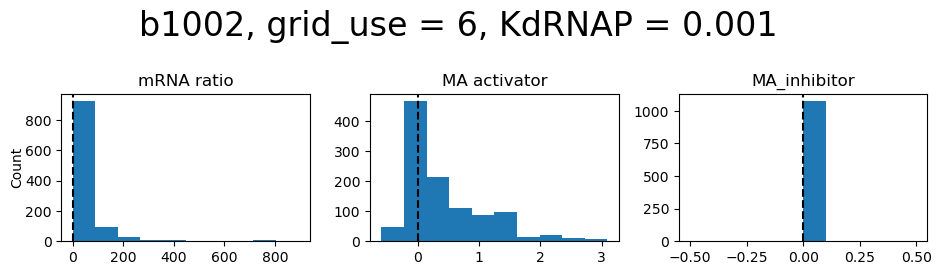

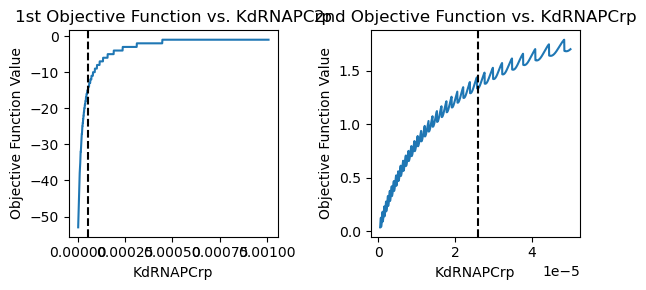

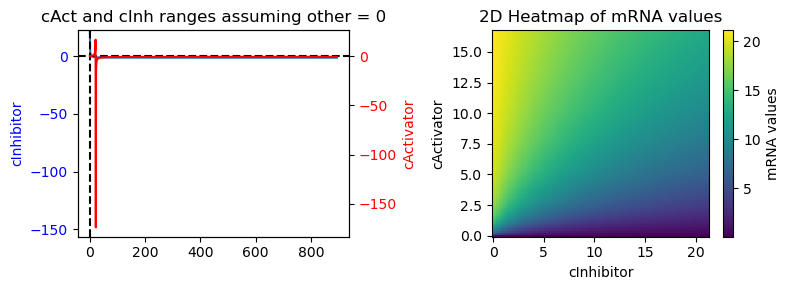

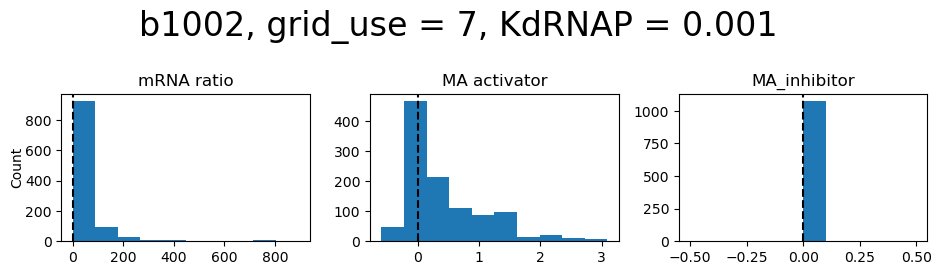

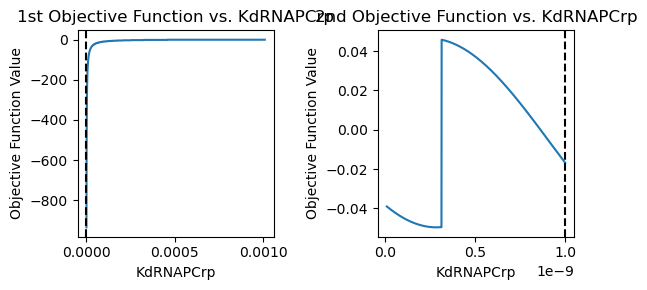

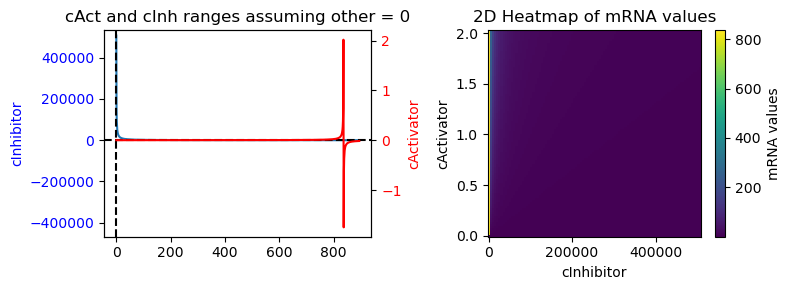

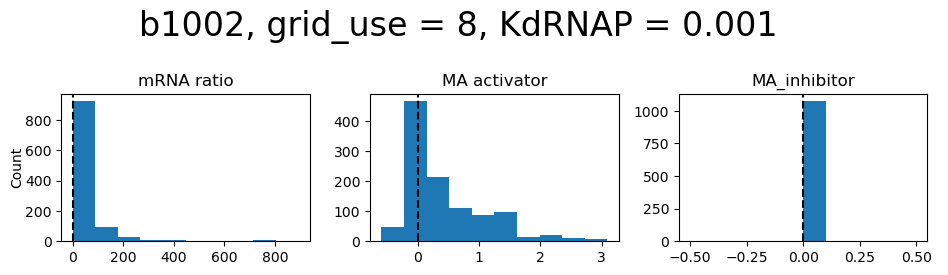

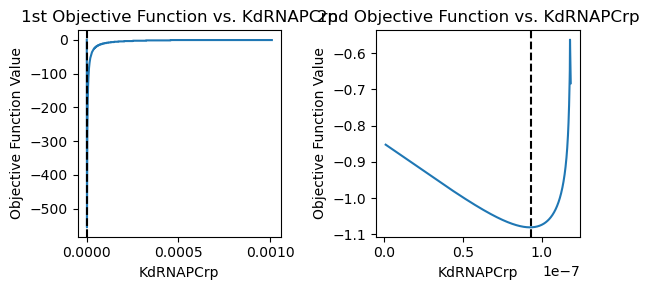

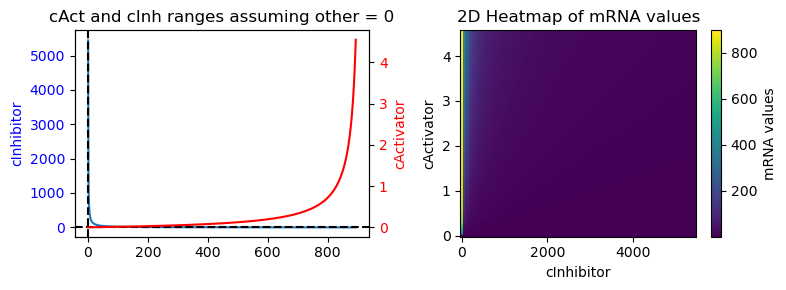

In [63]:
# display results
iter_ct += 1
#gene = genes[gene_int]

# looping created odd issues in when a figure would show up, not worth debugging for now, just do one by one
#for gene in genes[iter_ct*5: iter_ct*5 + 5]:

#gene = genes[iter_ct]
gene = 'b1002'
run_folder = '../data/saved_grid_results/'+gene
pickle_in = open(run_folder+'/run_to_grid_use.pkl', 'rb')
run_to_grid_use = pickle.load(pickle_in)
pickle_in.close()
for new_run_folder, grid_use in run_to_grid_use.items():
    #grid_use = run_to_grid_use[new_run_folder]
    pickle_in = open(new_run_folder+'/'+gene+'/figures.pkl', 'rb')
    results = pickle.load(pickle_in)
    pickle_in.close()
    cons_df = pd.read_pickle(new_run_folder+'/'+gene+'/constants.pkl')
    results[0].suptitle(gene+', grid_use = '+str(grid_use)+', KdRNAP = '+str(cons_df['KdRNAP']), fontsize = 24)
    results[0].tight_layout()
    show_figure(results[0])
    #plt.close()
    for result in results[1:]:
        #result[1].suptitle(gene+', grid_use = '+str(grid_use)+', KdRNAP = '+str(cons_df['KdRNAP']), fontsize = 24)
        #result[1].tight_layout()
        show_figure(result)
        #plt.close()

In [58]:
genes

[]

In [36]:
# KdRNAP values
for new_run_folder in runs:
    grid_use = run_to_grid_use[new_run_folder]
    if stable_flags['save_results']:
        results = []
        for gene in genes:
            pickle_in = open(new_run_folder+'/'+gene+'/figures.pkl', 'rb')
            results.append(pickle.load(pickle_in))
            pickle_in.close()
    cons_df = pd.read_pickle(new_run_folder+'/b2818/constants.pkl')
    print(cons_df['KdRNAP'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/saved_run_results/run_111/b2818/constants.pkl'